Dataset from: https://github.com/Shen0000/Soccer-Injury-Risk-Prediction/blob/master/assets/json/compiledData.json

In [ ]:
#imports and machine learning libraries
import json
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb

from xgboost import DMatrix, train
from scipy.stats import uniform, randint
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    confusion_matrix,
)

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving compiledData.json to compiledData.json


In [ ]:
#opening json file which is our data in read mode
with open("compiledData.json", "r") as file:
    data = json.load(file)

In [ ]:
#displaying json file
data

{'Minutes': [3150,
  3240,
  2020,
  2160,
  3420,
  180,
  1397,
  0,
  0,
  2027,
  2341,
  2610,
  2887,
  245,
  1917,
  1800,
  2168,
  22,
  2084,
  3298,
  1955,
  765,
  582,
  2918,
  797,
  2505,
  3412,
  3353,
  98,
  733,
  1873,
  1577,
  0,
  263,
  492,
  1991,
  135,
  44,
  1293,
  0,
  30,
  16,
  26,
  2190,
  3230,
  3403,
  3330,
  3420,
  3201,
  2670,
  23,
  0,
  175,
  2310,
  1328,
  2897,
  607,
  1912,
  61,
  205,
  982,
  1875,
  30,
  404,
  0,
  26,
  2119,
  2498,
  980,
  0,
  0,
  1343,
  1030,
  0,
  75,
  15,
  547,
  456,
  1773,
  168,
  0,
  2926,
  2433,
  3005,
  2191,
  1406,
  2604,
  2109,
  1883,
  1529,
  2750,
  661,
  1780,
  1521,
  2151,
  2042,
  2334,
  3090,
  2377,
  229,
  131,
  131,
  284,
  3062,
  281,
  33,
  235,
  118,
  1033,
  2222,
  1716,
  53,
  0,
  0,
  1710,
  1710,
  3110,
  90,
  450,
  180,
  270,
  1451,
  310,
  0,
  0,
  1710,
  1233,
  2968,
  2592,
  2672,
  1223,
  1396,
  822,
  1179,
  134,
  483,
  2010

In [ ]:
#columns that need to be converted from strings to integers
csv_parameters = ['Name', 'Position', 'Appearances', 'Assists', 'Passes', 'Yellow cards', 'Red cards', 'Fouls', 'Tackles']

In [ ]:
#converting columns from strings to integers, excluding name and position
for parameter in csv_parameters:
  if parameter not in ['Name', 'Position']:
    for i in range(len(data[parameter])):
      data[parameter][i] = int(data[parameter][i])

In [ ]:
#creating pandas dataframe from 'data' and displaying it
df = pd.DataFrame.from_dict(data)
df

,Minutes,Injured,Recovering,Age,Height,Name,Position,Appearances,Assists,Passes,Yellow cards,Red cards,Fouls,Tackles
0,3150,1,1,25,0.00,Thibaut Courtois,Goalkeeper,35,0,983,2,0,2,0
1,3240,1,1,24,0.00,Thibaut Courtois,Goalkeeper,36,0,792,1,0,1,0
2,2020,1,1,23,0.00,Thibaut Courtois,Goalkeeper,23,0,523,1,2,2,0
3,2160,1,0,31,1.99,Asmir Begovic,Goalkeeper,24,0,530,0,0,0,0
4,3420,0,0,30,1.99,Asmir Begovic,Goalkeeper,38,0,945,2,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,1490,0,0,28,1.75,Romaine Sawyers,Midfielder,19,0,720,2,0,18,30
3258,1192,1,0,28,1.91,Mbaye Diagne,Forward,16,2,235,2,0,17,4
3259,0,0,0,20,0.00,Cheikh Diaby,Forward,0,0,0,0,0,0,0
3260,0,0,0,21,1.85,Richard Nartey,Defender,0,0,0,0,0,0,0


In [ ]:
#testing if our dataframe works
df[10:15]

,Minutes,Injured,Recovering,Age,Height,Name,Position,Appearances,Assists,Passes,Yellow cards,Red cards,Fouls,Tackles
10,2341,0,0,24,1.9,Kurt Zouma,Defender,28,0,2080,6,0,30,23
11,2610,0,1,23,1.9,Kurt Zouma,Defender,32,2,1442,3,1,20,32
12,2887,1,0,22,1.9,Kurt Zouma,Defender,34,0,1021,1,0,19,50
13,245,0,1,21,1.9,Kurt Zouma,Defender,9,1,128,0,0,2,8
14,1917,1,1,20,1.9,Kurt Zouma,Defender,23,1,736,0,0,9,30


In [ ]:
#calculating mean height and replacing 0.0 height as missing (NaN)
mean_height = df['Height'].replace(0.0, np.nan).mean(axis=0)

#replacing 0.0 with mean height
df['Height'].replace(0.0, mean_height, inplace=True)

/tmp/ipython-input-3551996609.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Height'].replace(0.0, mean_height, inplace=True)


In [ ]:
#testing
df[322:323]

,Minutes,Injured,Recovering,Age,Height,Name,Position,Appearances,Assists,Passes,Yellow cards,Red cards,Fouls,Tackles
322,1373,1,1,26,1.75,Theo Walcott,Forward,28,2,310,0,0,3,11


array([[<Axes: title={'center': 'Minutes'}>,
        <Axes: title={'center': 'Injured'}>,
        <Axes: title={'center': 'Recovering'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Appearances'}>],
       [<Axes: title={'center': 'Assists'}>,
        <Axes: title={'center': 'Passes'}>,
        <Axes: title={'center': 'Yellow cards'}>],
       [<Axes: title={'center': 'Red cards'}>,
        <Axes: title={'center': 'Fouls'}>,
        <Axes: title={'center': 'Tackles'}>]], dtype=object)

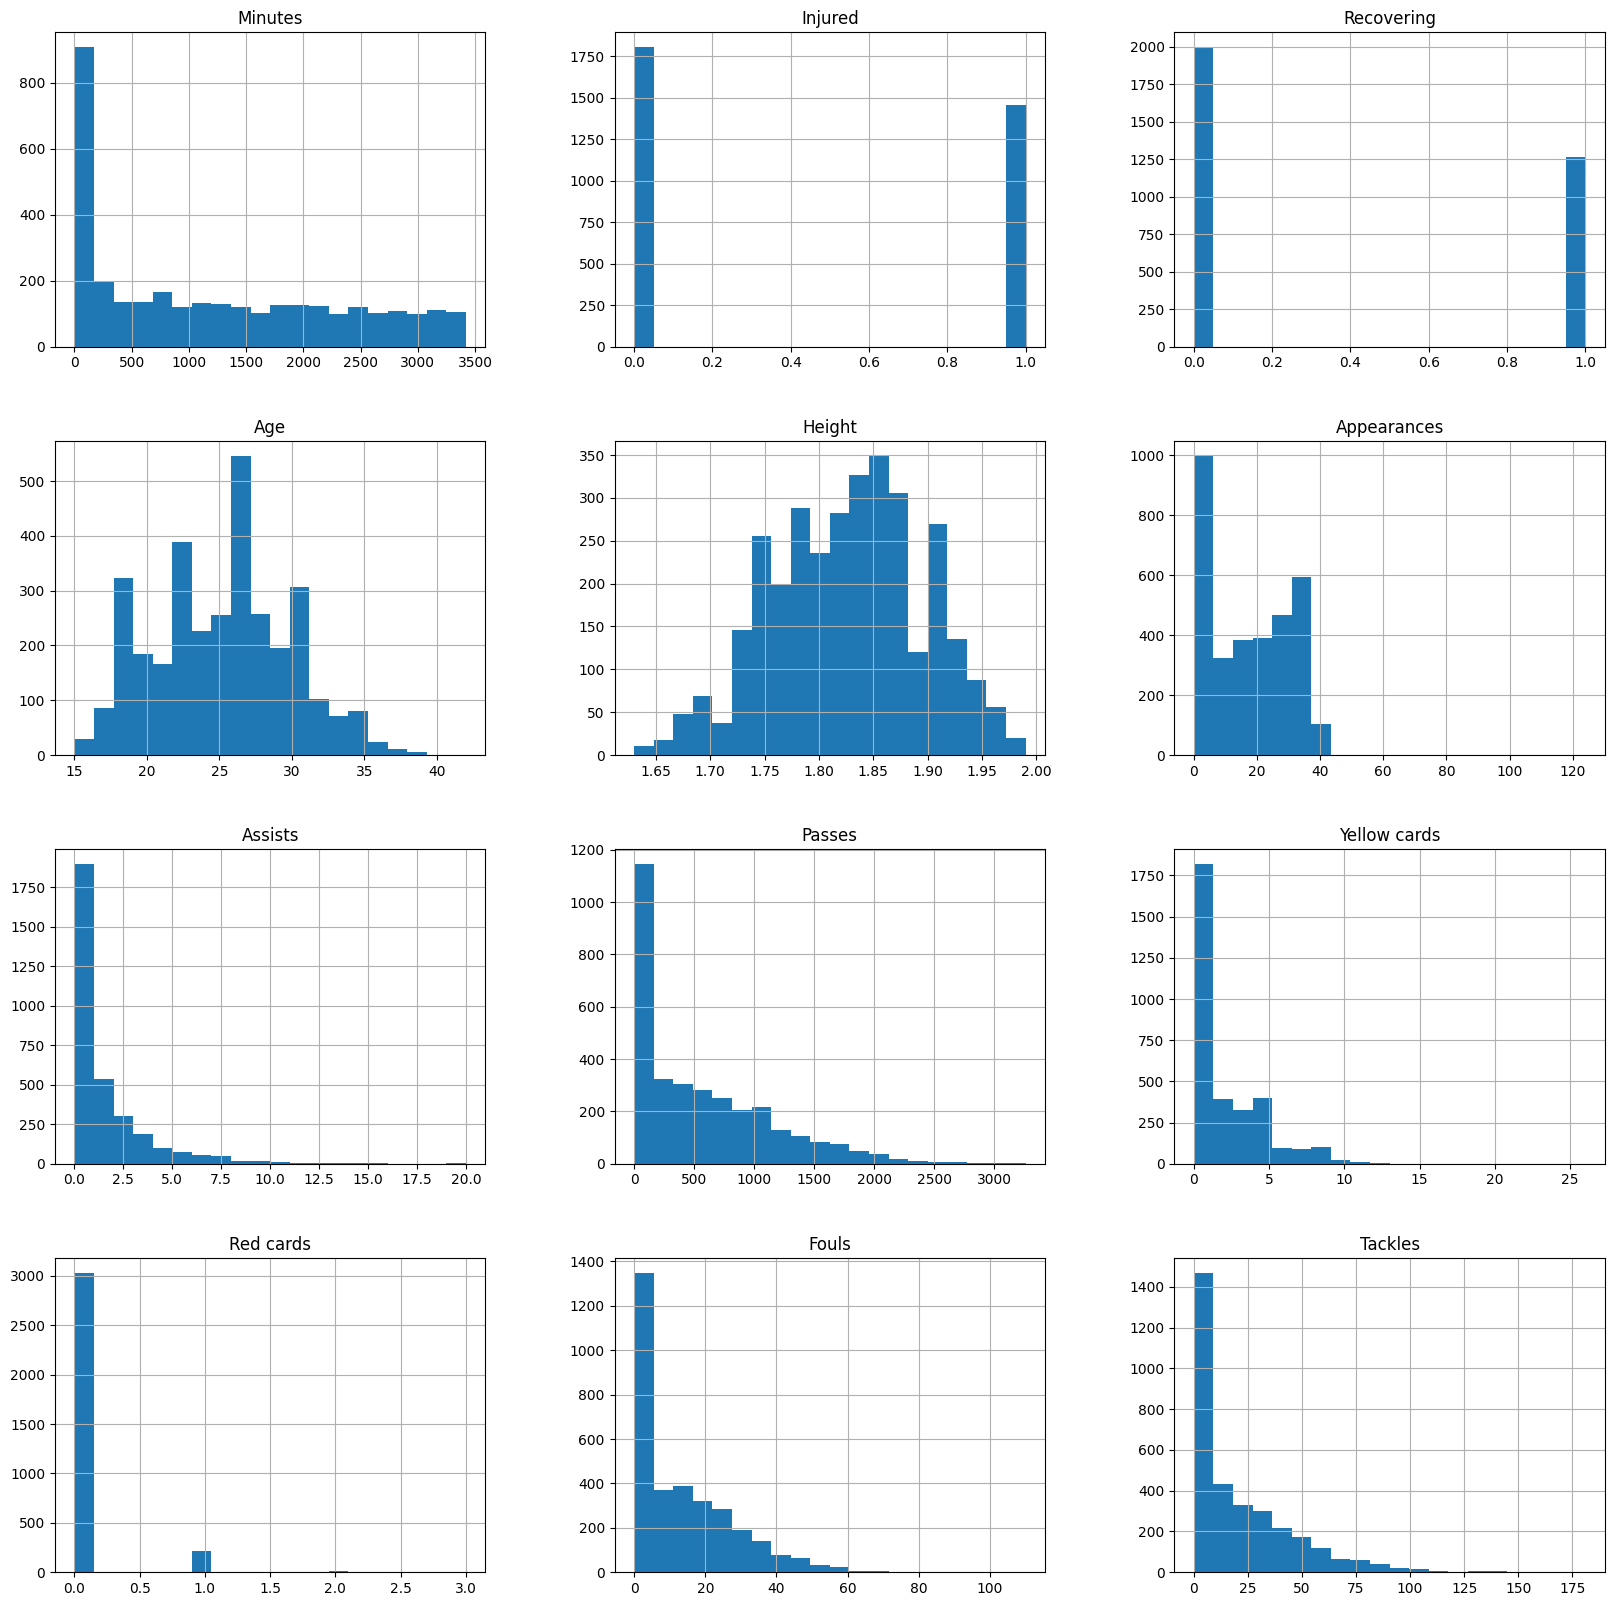

In [ ]:
#plotting bargraphs for all columns with 20 bins and a 20,20 figure size
df.hist(bins=20, figsize=(20,20))

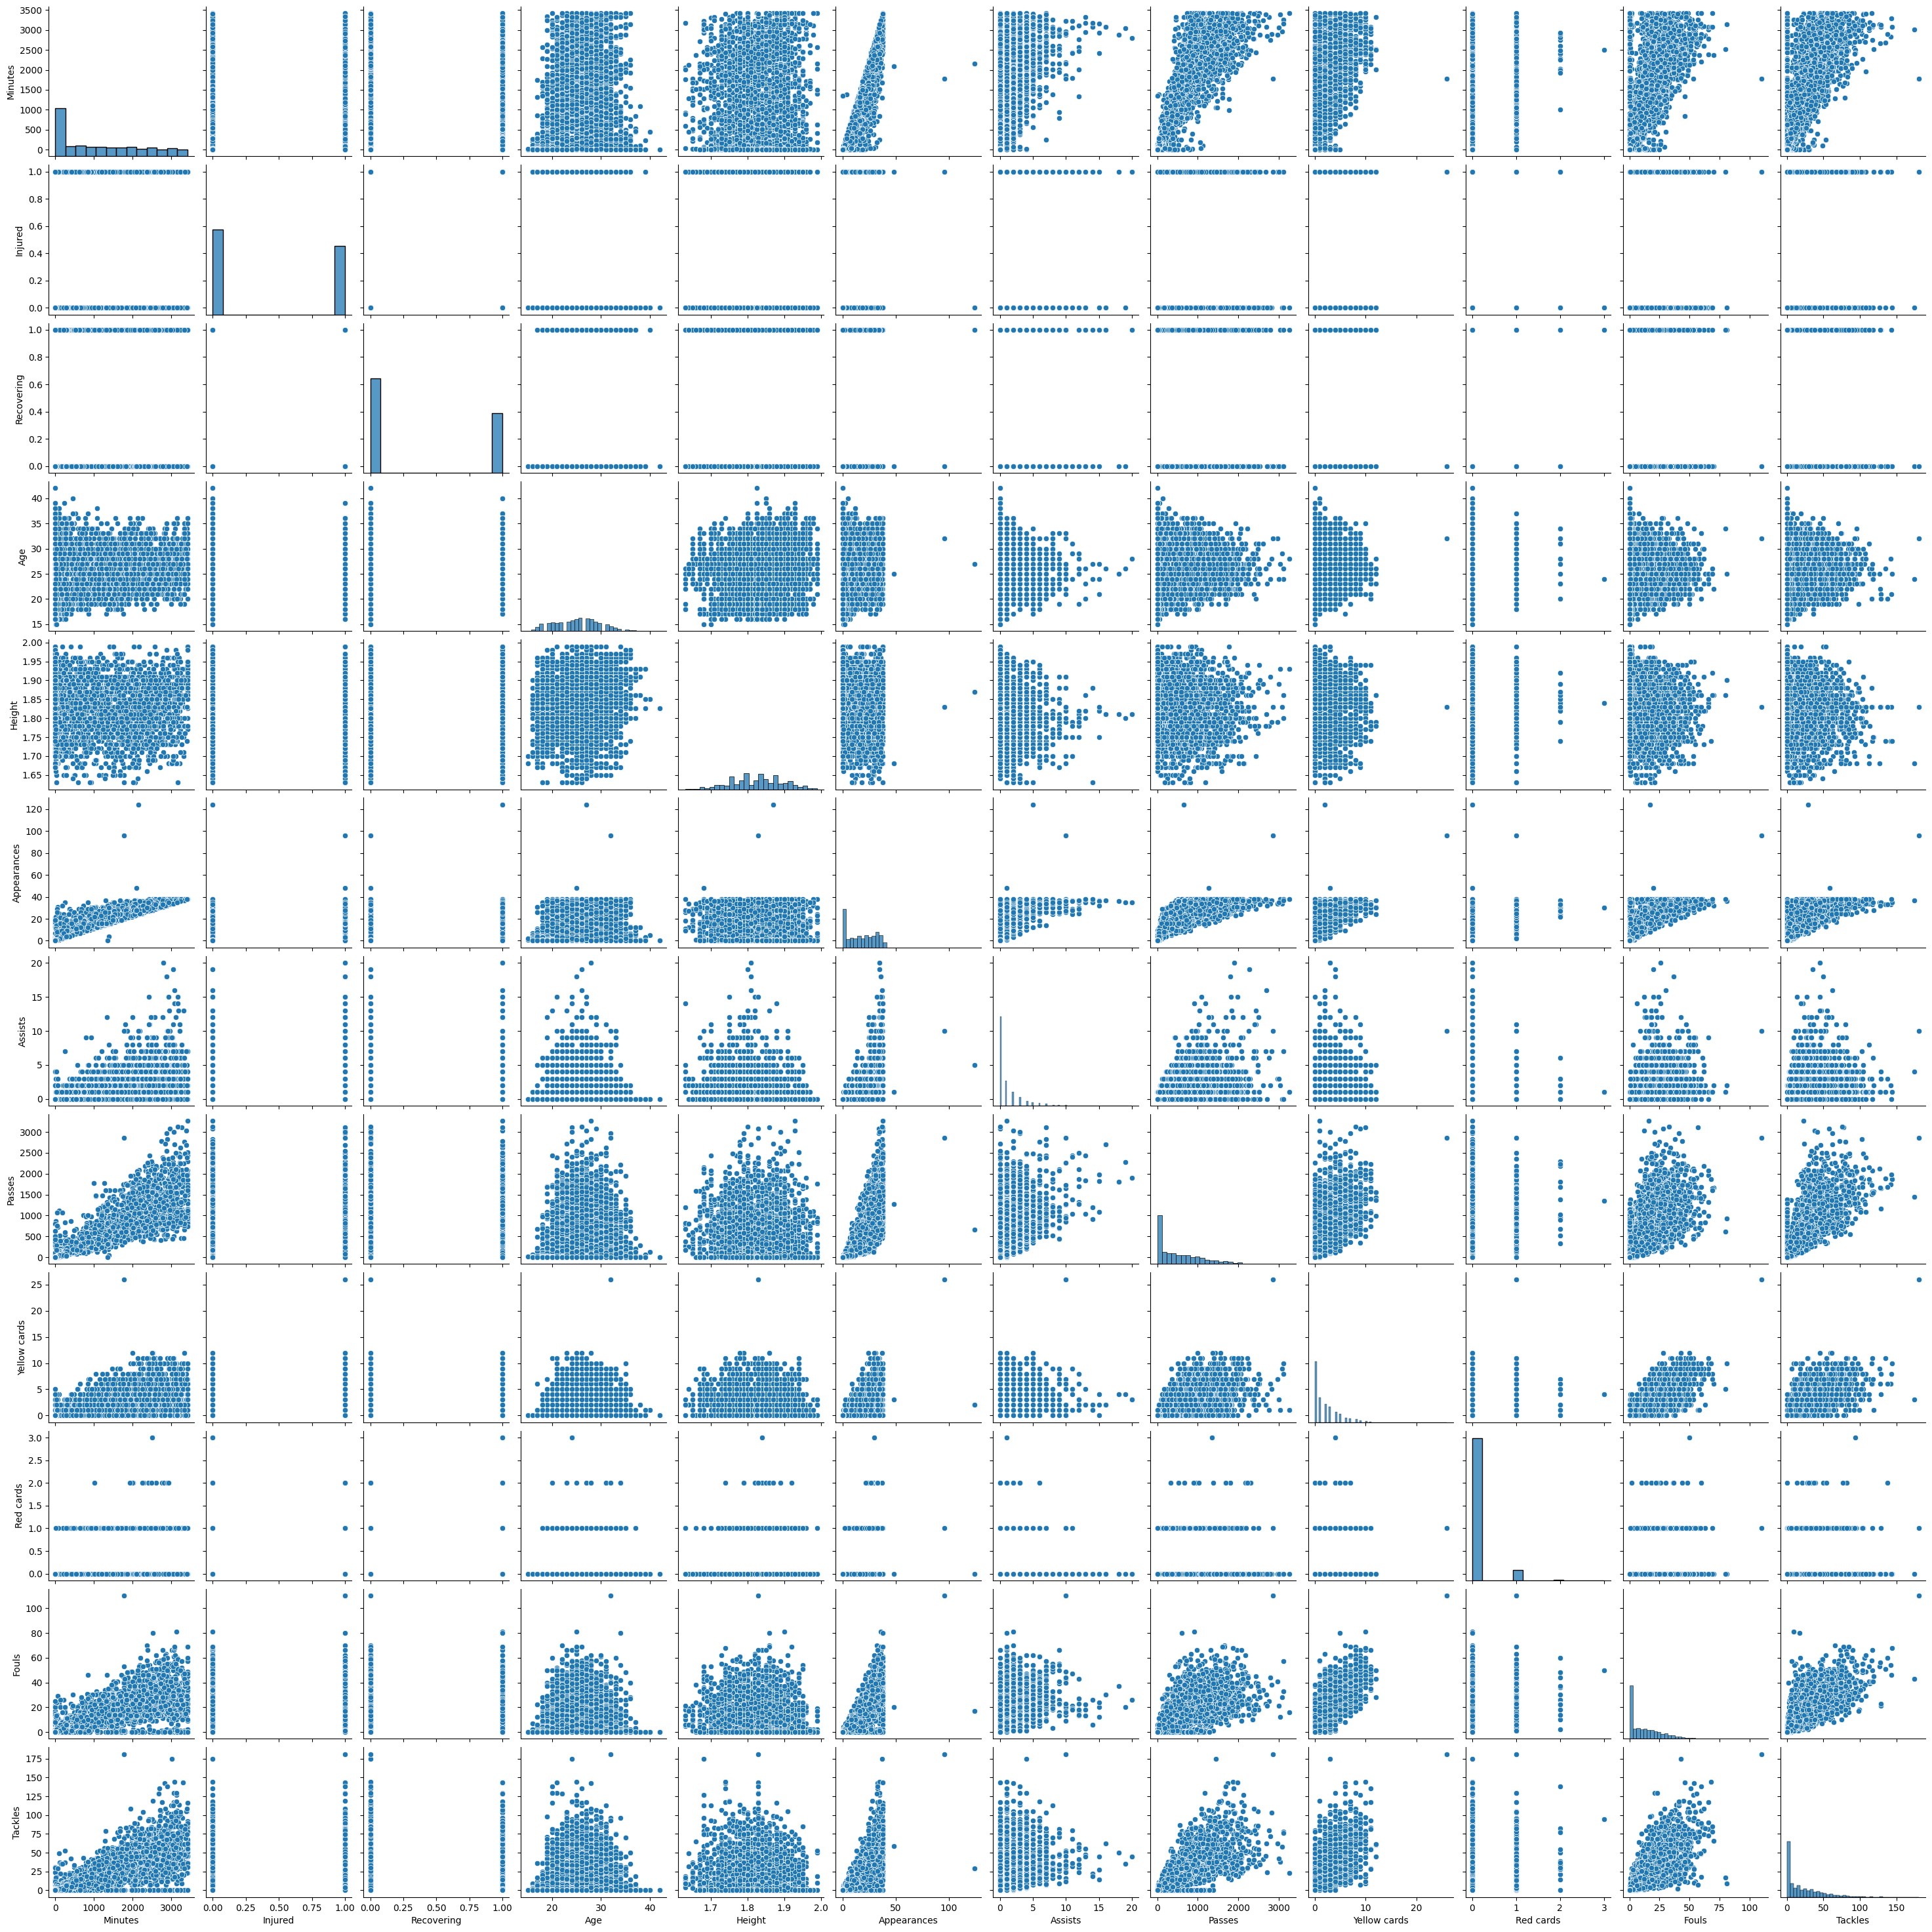

In [ ]:
# creating pairplot to see relationships between different features
sns.pairplot(df)

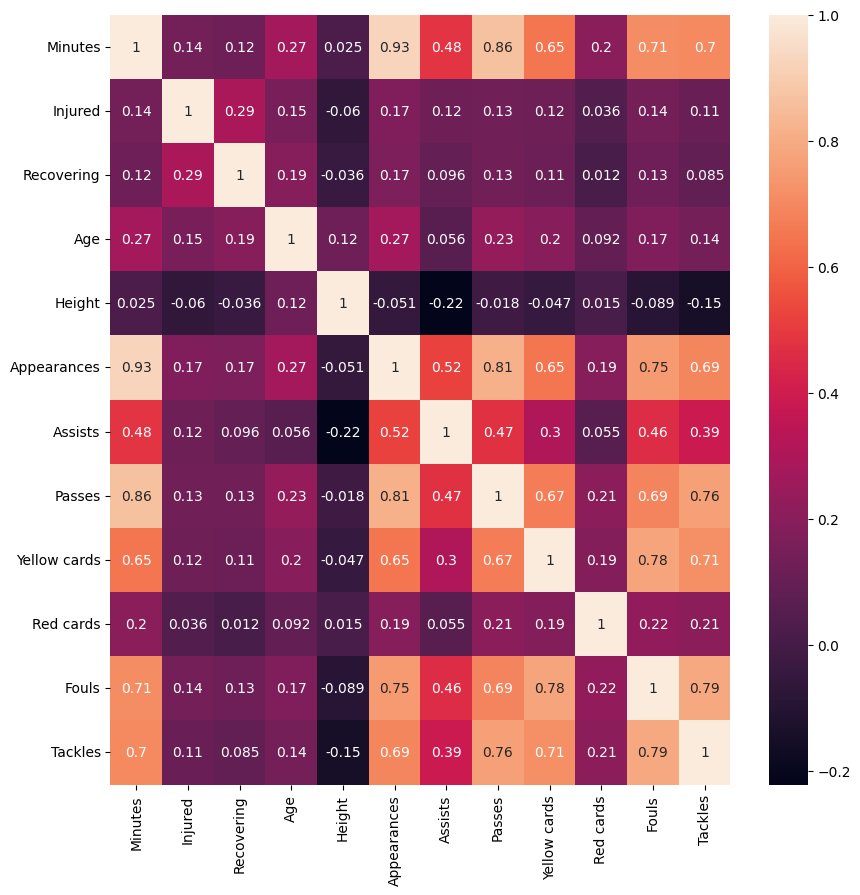

In [ ]:
plt.figure(figsize=(10,10))
corr_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(corr_matrix, annot=True)

#saving the plot as PNG file
plt.savefig("soccer-dataset-correlation.png", dpi=1200)

In [ ]:
le_position = LabelEncoder()

In [ ]:
df['Position_n'] = le_position.fit_transform(df['Position'])

In [ ]:
df.loc[df['Name'] == "Adrián"]

,Minutes,Injured,Recovering,Age,Height,Name,Position,Appearances,Assists,Passes,Yellow cards,Red cards,Fouls,Tackles,Position_n
910,270,0,0,33,1.9,Adrián,Goalkeeper,3,0,80,0,0,0,0,2
911,873,0,0,32,1.9,Adrián,Goalkeeper,11,0,260,1,0,0,0,2
912,0,0,0,31,1.9,Adrián,Goalkeeper,0,0,0,0,0,0,0,2
913,1710,0,0,30,1.9,Adrián,Goalkeeper,19,0,520,2,0,1,0,2
914,1440,0,1,29,1.9,Adrián,Goalkeeper,16,0,417,1,0,0,0,2
915,2880,1,0,28,1.9,Adrián,Goalkeeper,32,0,853,1,1,1,0,2


In [ ]:
df

,Minutes,Injured,Recovering,Age,Height,Name,Position,Appearances,Assists,Passes,Yellow cards,Red cards,Fouls,Tackles,Position_n
0,3150,1,1,25,1.825454,Thibaut Courtois,Goalkeeper,35,0,983,2,0,2,0,2
1,3240,1,1,24,1.825454,Thibaut Courtois,Goalkeeper,36,0,792,1,0,1,0,2
2,2020,1,1,23,1.825454,Thibaut Courtois,Goalkeeper,23,0,523,1,2,2,0,2
3,2160,1,0,31,1.990000,Asmir Begovic,Goalkeeper,24,0,530,0,0,0,0,2
4,3420,0,0,30,1.990000,Asmir Begovic,Goalkeeper,38,0,945,2,0,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3257,1490,0,0,28,1.750000,Romaine Sawyers,Midfielder,19,0,720,2,0,18,30,3
3258,1192,1,0,28,1.910000,Mbaye Diagne,Forward,16,2,235,2,0,17,4,1
3259,0,0,0,20,1.825454,Cheikh Diaby,Forward,0,0,0,0,0,0,0,1
3260,0,0,0,21,1.850000,Richard Nartey,Defender,0,0,0,0,0,0,0,0


In [ ]:
#creating input features by dropping target and non-predictive columns
inputs = df.drop(['Injured', 'Name', 'Position', 'Height', 'Position_n', 'Tackles', 'Red cards', 'Yellow cards', 'Assists', 'Passes', 'Fouls'], axis='columns')

#creating target variable (Injured) by dropping all feature columns
targets = df.drop(['Minutes', 'Name', 'Position', 'Appearances', 'Assists', 'Passes', 'Yellow cards', 'Red cards', 'Fouls', 'Tackles', 'Position_n', 'Recovering', 'Age', 'Height'], axis='columns')

print(inputs.head())
print(targets.head())

   Minutes  Recovering  Age  Appearances
0     3150           1   25           35
1     3240           1   24           36
2     2020           1   23           23
3     2160           0   31           24
4     3420           0   30           38
   Injured
0        1
1        1
2        1
3        1
4        0


In [ ]:
scaler = MinMaxScaler()

#fiiting and transforming the input data
in_scaled = scaler.fit_transform(inputs.to_numpy())

#converting the scaled array back to a data frame
in_scaled = pd.DataFrame(in_scaled, columns=inputs.columns)


print("Scaled Dataset Using MinMaxScaler")
inputs = in_scaled

#displaying few rows of the top
in_scaled.head()

Scaled Dataset Using MinMaxScaler


,Minutes,Recovering,Age,Appearances
0,0.921053,1.0,0.370370,0.282258
1,0.947368,1.0,0.333333,0.290323
2,0.590643,1.0,0.296296,0.185484
3,0.631579,0.0,0.592593,0.193548
4,1.000000,0.0,0.555556,0.306452


In [ ]:
#checking shape of inputs
inputs.shape

(3262, 4)

In [ ]:
#checking shape of targets
targets.shape

(3262, 1)

In [ ]:
#displaying cross-validation scores
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [ ]:
#reporting the top n best models from the search results
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
#assigning features and target
X, y = inputs, targets
xgb_model = xgb.XGBClassifier()

#defining parameter distributions for randomized search
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

#initializing RandomizedSearchCV with 3-fold cross-validation
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.666 (std: 0.021)
Parameters: {'colsample_bytree': np.float64(0.7516959613604889), 'gamma': np.float64(0.09614450940433539), 'learning_rate': np.float64(0.042260584879943656), 'max_depth': 2, 'n_estimators': 117, 'subsample': np.float64(0.7114361356127834)}



In [ ]:
#splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

In [ ]:
#defining the best parameters found until now
params = {'colsample_bytree': 0.7516959613604889, 'gamma': 0.09614450940433539, 'learning_rate': 0.042260584879943656, 'max_depth': 2, 'n_estimators': 117, 'subsample': 0.7114361356127834}

#initializing the model with parameters
test = xgb.XGBClassifier(parameters = params)

#training and scoring the model on test data
test.fit(X_train, y_train)
test.score(X_test, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:04:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "parameters" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.6447166921898928

In [ ]:
#computing confusion matrix
confusion_matrix(y_test, test.predict(X_test))

array([[237, 134],
       [ 98, 184]])

Best iteration: 8


/usr/local/lib/python3.12/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


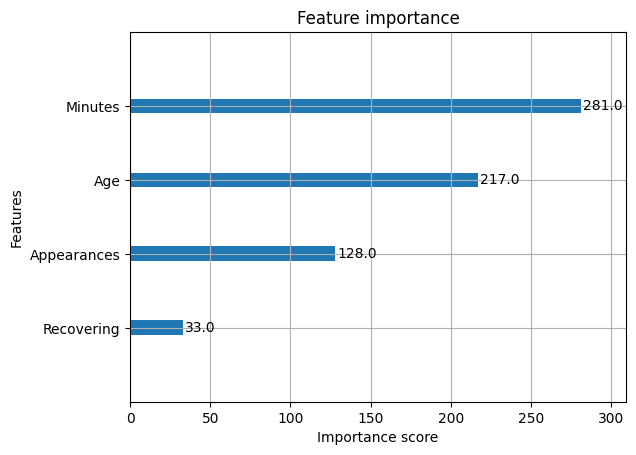

In [ ]:
#final train test split
X_train, X_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.2, random_state=968
)

#creating DMatrix for train and test data

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eta": 0.2,
    "gamma": 0.2,
    "max_depth": 5,
    "eval_metric": "auc"
}


#defining parameters for native API
params = {
    "objective": "binary:logistic",
    "eta": 0.2,
    "gamma": 0.2,
    "max_depth": 5,
    "eval_metric": "auc"
}

evals = [(dtrain, "train"), (dtest, "eval")]
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=70,
    evals=evals,
    early_stopping_rounds=25,
    verbose_eval=False,
)

#probabilities and labels used everywhere
y_pred_prob = booster.predict(dtest)
y_pred      = (y_pred_prob >= 0.5).astype(int)

#single AUC value used for both ROC and table
auc_val = roc_auc_score(y_test, y_pred_prob)

print("Best iteration:", booster.best_iteration)

#vizualizing the best tree
from xgboost import to_graphviz
to_graphviz(booster, num_trees=booster.best_iteration)


#vizualizing feature importance
from xgboost import plot_importance
import matplotlib.pyplot as plt

plot_importance(booster)
plt.show()


In [ ]:
#getting predicted probabilities
y_pred_prob = booster.predict(dtest)

#converting to binary predictions
y_pred = [1 if p > 0.5 else 0 for p in y_pred_prob]

#evaluating using sklearn
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")
print(accuracy_score(y_test, y_pred), ": is the accuracy score")
print(precision_score(y_test, y_pred), ": is the precision score")
print(recall_score(y_test, y_pred), ": is the recall score")
print(f1_score(y_test, y_pred), ": is the f1 score")


[[242 129]
 [ 92 190]] : is the confusion matrix
0.6615620214395099 : is the accuracy score
0.5956112852664577 : is the precision score
0.6737588652482269 : is the recall score
0.632279534109817 : is the f1 score


Text(95.72222222222221, 0.5, 'True')

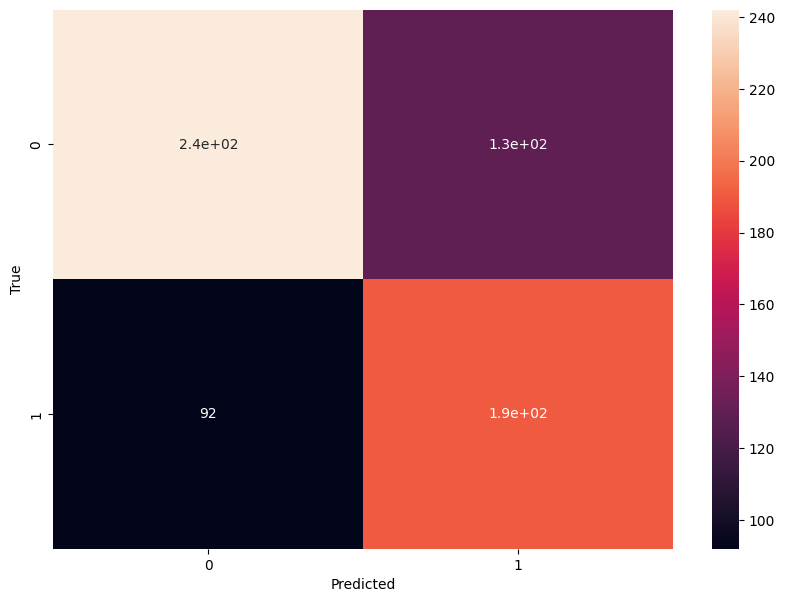

In [ ]:
#plotting heatmap of the confusion matrix

cm = confusion_matrix(y_test, y_pred)

%matplotlib inline
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

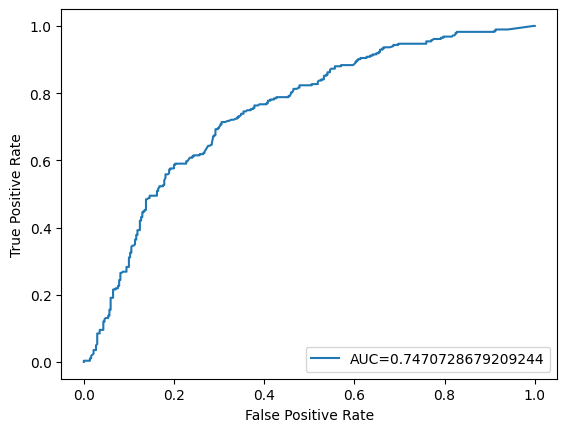

In [ ]:
#predicting injury probabilities for the test set using the trained XGBoost booster
y_pred_prob = booster.predict(dtest)

#computing false positive rate, true positive rate, and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

#computing Area Under the ROC Curve (AUC) using predicted probabilities
auc = roc_auc_score(y_test, y_pred_prob)


#creating ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#running 10 fold cross-validation on the first XGBoost model
score=cross_val_score(xgb_model,X,y,cv=10)
print(score)
print(score.mean(), score.std())

[0.60244648 0.56269113 0.68404908 0.60122699 0.59815951 0.63496933
 0.57361963 0.65030675 0.6809816  0.69018405]
0.6278634547194236 0.04454669965745061


In [ ]:
#defining a new XGBoost classifier for our final model
xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", n_estimators=25, random_state=10, eval_metric=["auc", "error", "error@0.6"], max_depth=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
xgb_model2.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.75078	validation_0-error:0.32925	validation_0-error@0.6:0.44564
[1]	validation_0-auc:0.74921	validation_0-error:0.33231	validation_0-error@0.6:0.43032
[2]	validation_0-auc:0.74991	validation_0-error:0.32772	validation_0-error@0.6:0.41501
[3]	validation_0-auc:0.75453	validation_0-error:0.32925	validation_0-error@0.6:0.37213
[4]	validation_0-auc:0.76025	validation_0-error:0.31853	validation_0-error@0.6:0.36141
[5]	validation_0-auc:0.75831	validation_0-error:0.30781	validation_0-error@0.6:0.34303
[6]	validation_0-auc:0.75791	validation_0-error:0.29250	validation_0-error@0.6:0.33844
[7]	validation_0-auc:0.75671	validation_0-error:0.29556	validation_0-error@0.6:0.34763
[8]	validation_0-auc:0.75682	validation_0-error:0.29403	validation_0-error@0.6:0.34916
[9]	validation_0-auc:0.75574	validation_0-error:0.29709	validation_0-error@0.6:0.35069
[10]	validation_0-auc:0.75554	validation_0-error:0.29709	validation_0-error@0.6:0.34456
[11]	validation_0-auc:0.75670	validation_0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=['auc', 'error', 'error@0.6'], feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=25,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
#accuracy of the final XGBoost model on the test set
xgb_model2.score(X_test, y_test)

0.6722817764165391

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets)
n_folds = 10
early_stopping = 20

#XGBoost hyperparameters used in cross-validation
params = {'booster':'gbtree', 'eta': 0.1, 'max_depth': 4, 'objective': 'binary:logistic', 'eval_metric':['auc', 'error'], 'nthread':4}

#converting full dataset into XGBoost DMatrix format
xg_train = xgb.DMatrix(inputs, label=targets);

#running cross validation for max 500 boosting rounds
cv = xgb.cv(params, xg_train, 500, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)

[0]	train-auc:0.73392+0.00219	train-error:0.44666+0.00217	test-auc:0.70974+0.02800	test-error:0.44665+0.01949
[1]	train-auc:0.73881+0.00335	train-error:0.43906+0.02076	test-auc:0.71179+0.02891	test-error:0.44205+0.03182
[2]	train-auc:0.74227+0.00298	train-error:0.34474+0.01622	test-auc:0.71349+0.02873	test-error:0.36297+0.02846
[3]	train-auc:0.74334+0.00298	train-error:0.33166+0.00414	test-auc:0.71602+0.03050	test-error:0.34733+0.02760
[4]	train-auc:0.74632+0.00220	train-error:0.33109+0.00354	test-auc:0.71796+0.02871	test-error:0.34059+0.02628
[5]	train-auc:0.74717+0.00283	train-error:0.33061+0.00342	test-auc:0.71898+0.02792	test-error:0.34059+0.02524
[6]	train-auc:0.74912+0.00264	train-error:0.32856+0.00464	test-auc:0.72076+0.02613	test-error:0.34028+0.02459
[7]	train-auc:0.75145+0.00355	train-error:0.32625+0.00456	test-auc:0.72226+0.02554	test-error:0.34028+0.02576
[8]	train-auc:0.75265+0.00364	train-error:0.32656+0.00443	test-auc:0.72454+0.02556	test-error:0.33906+0.02651
[9]	train-

In [ ]:
results = []

acc       = accuracy_score(y_test, y_pred) * 100
precision = precision_score(y_test, y_pred) * 100
recall    = recall_score(y_test, y_pred) * 100
f1        = f1_score(y_test, y_pred) * 100
kfold     = cross_val_score(
    xgb.XGBClassifier(objective="binary:logistic",
                      eta=0.2, gamma=0.2, max_depth=5,
                      eval_metric="auc"),
    inputs, targets, cv=10
).mean() * 100

results.append([
    "XGBoost",
    round(auc_val, 4),
    round(acc, 2),
    round(precision, 2),
    round(recall, 2),
    round(f1, 2),
    round(kfold, 2),
])

df = pd.DataFrame(
    results,
    columns=["Model", "AUC", "Accuracy (%)",
             "Precision", "Recall", "F1", "K fold"]
)
print(df.to_string(index=False))


  Model    AUC  Accuracy (%)  Precision  Recall    F1  K fold
XGBoost 0.7471         69.68      63.24   71.73 67.22   64.81


/tmp/ipython-input-3325886369.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=True)


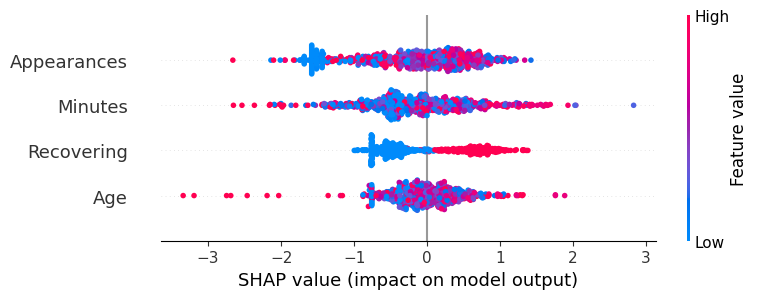

In [ ]:
#SHAP
xgb_model.fit(X_train, y_train)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=True)
shap.initjs()